In [1]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [2]:
!pip install vit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.6/97.6 kB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.6/314.6 kB 5.9 MB/s eta 0:00:00
  Created wheel for tasklib: filename=tasklib-2.5.1-py3-none-any.whl size=25472 sha256=9dec68e8c30ce1361b9f517f89ef26e21cab8ed022a74baceb77dd3b9ef1646c
  Stored in directory: /root/.cache/pip/wheels/4c/c6/a5/dbc781785a2d22a487b78194c5f2a6cff338fa1eb42acd5762
Successfully built tasklib


In [3]:
!pip install utils

  Preparing metadata (setup.py) ... done
  Created wheel for utils: filename=utils-1.0.2-py2.py3-none-any.whl size=13905 sha256=771408bc481e37190dec2ef2fe4fa65ab63c3f81541189bfd6d8a89c8ff25290
  Stored in directory: /root/.cache/pip/wheels/b8/39/f5/9d0ca31dba85773ececf0a7f5469f18810e1c8a8ed9da28ca7
Successfully built utils


In [5]:
import tensorflow as tf
from vit import ViTClassfier
from utils import plot_grid_ds, AttrDict, BalancedSparseCategoricalAccuracy

In [8]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os


path = Path("/content/drive/MyDrive/Kalbe/HW 2/Brain/Training")
img_as_jpg = list(path.glob(r"*/*.jpg"))

# Counts the number of each categories in the dataset
file_count = list(map(lambda x: os.path.split(os.path.split(x)[0])[1],img_as_jpg))
glioma = file_count.count('glioma')
meningioma = file_count.count('meningioma')
notumor = file_count.count('notumor')
pituitary = file_count.count('pituitary')

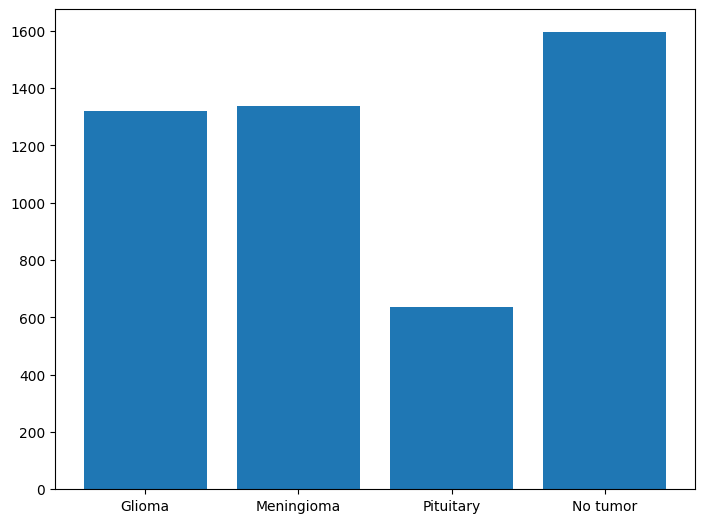

In [9]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
labels = ['Glioma','Meningioma', 'Pituitary', 'No tumor']
count_train = [glioma, meningioma, pituitary, notumor]
ax.bar(labels, count_train)
plt.show()

In [10]:
train = pd.concat([pd.Series(img_as_jpg,name="image").apply(str),pd.Series(file_count, name="type")],axis=1)
train = train.sample(frac=1).reset_index(drop=True)
print(np.shape(train))

(4891, 2)


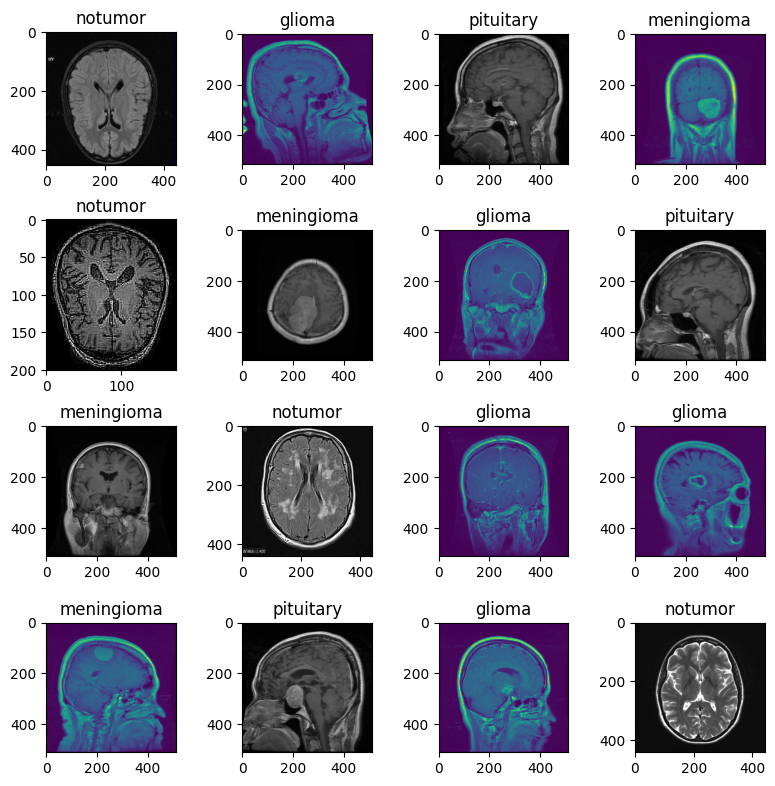

In [11]:
fig, axes = plt.subplots(4, 4, figsize=(8, 8))
fig.tight_layout()
counter = 0
for ax in axes.reshape(-1):
    ax.imshow(plt.imread(train["image"][counter]))
    ax.set_title(train["type"][counter])
    plt.rcParams["axes.grid"] = False
    counter = counter+1

In [13]:
hparams = AttrDict(
    image_size=(128, 128, 3),
    n_classes=4,
    batch_size=64,
)

ds = tf.keras.preprocessing.image_dataset_from_directory("/content/drive/MyDrive/Kalbe/HW 2/Brain/Training", image_size=hparams.image_size[:-1], batch_size=hparams.batch_size)
train_split = round(0.8 * ds.cardinality().numpy())
train_ds = ds.take(train_split); train_ds.class_names = ds.class_names
validation_ds = ds.skip(train_split); validation_ds.class_names = ds.class_names

Found 4891 files belonging to 4 classes.


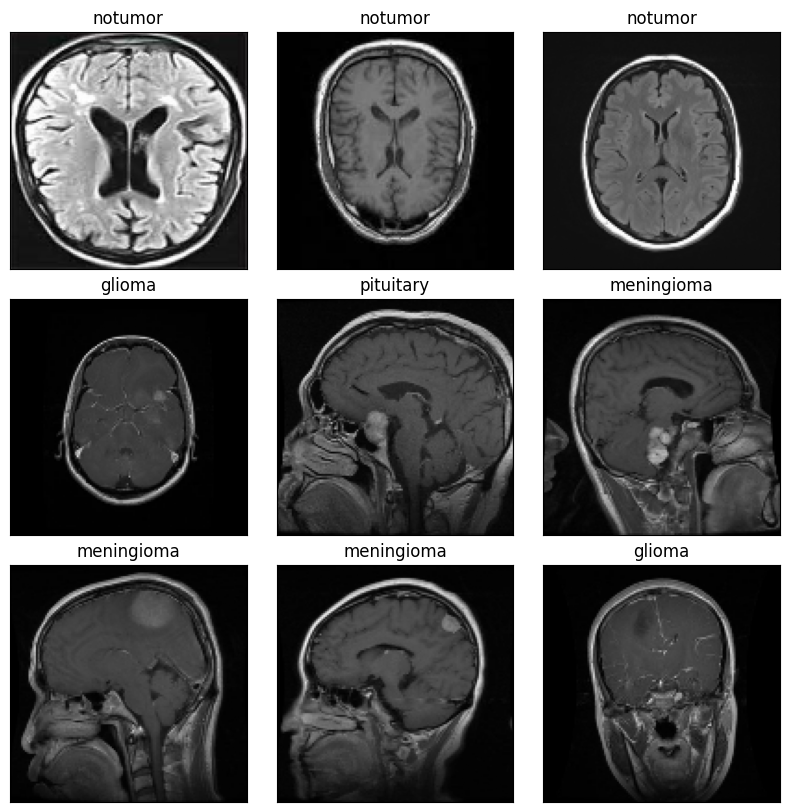

In [14]:
_ = plot_grid_ds(train_ds)

In [15]:
strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    model = ViTClassfier(hparams.image_size, hparams.n_classes)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=["accuracy", BalancedSparseCategoricalAccuracy()]
    )

In [16]:
model.fit(train_ds, epochs=20, validation_data=validation_ds)

Epoch 1/20
62/62 [==============================] - 431s 7s/step - loss: 4.3807 - accuracy: 0.6283 - balanced_sparse_categorical_accuracy: 0.5910 - val_loss: 0.3990 - val_accuracy: 0.8559 - val_balanced_sparse_categorical_accuracy: 0.8387
Epoch 2/20
62/62 [==============================] - 181s 3s/step - loss: 0.4315 - accuracy: 0.8485 - balanced_sparse_categorical_accuracy: 0.8312 - val_loss: 0.2922 - val_accuracy: 0.9036 - val_balanced_sparse_categorical_accuracy: 0.9049
Epoch 3/20
62/62 [==============================] - 194s 3s/step - loss: 0.3498 - accuracy: 0.8758 - balanced_sparse_categorical_accuracy: 0.8692 - val_loss: 0.3352 - val_accuracy: 0.8765 - val_balanced_sparse_categorical_accuracy: 0.8860
Epoch 4/20
62/62 [==============================] - 192s 3s/step - loss: 0.2771 - accuracy: 0.8967 - balanced_sparse_categorical_accuracy: 0.8905 - val_loss: 0.2154 - val_accuracy: 0.9231 - val_balanced_sparse_categorical_accuracy: 0.9209
Epoch 5/20
62/62 [==========================

1/1 [==============================] - 1s 841ms/step


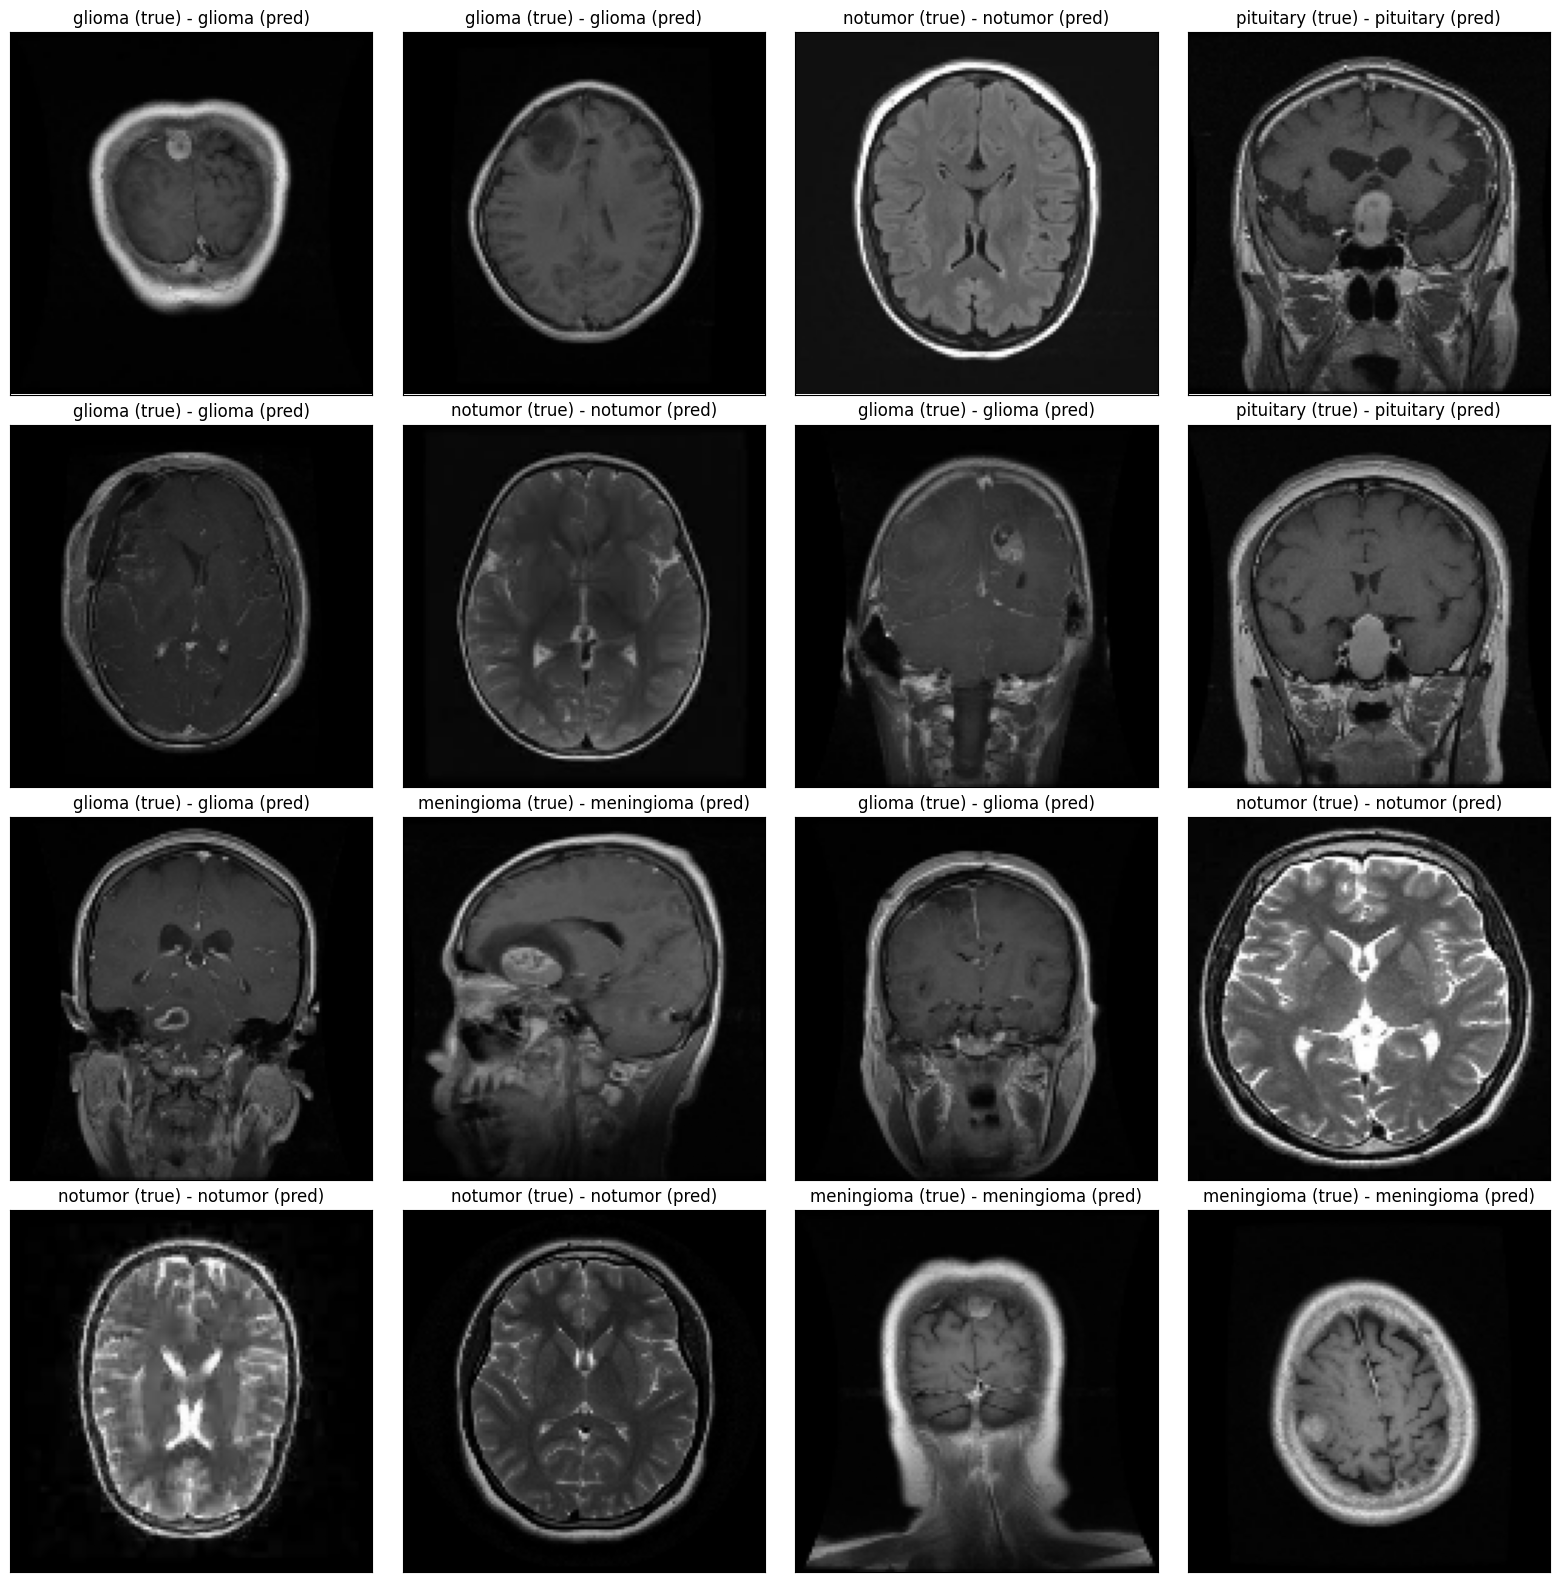

In [17]:
_ = plot_grid_ds(validation_ds, size=(4, 4), model=model, figsize= (20,20))

In [18]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

X, y_true = list(zip(*[(X, y) for (X, y) in validation_ds.unbatch().as_numpy_iterator()]))
y_hat = model.predict_on_batch(np.array(X)).argmax(axis=-1)
mat = confusion_matrix(y_true, y_hat)
mat

array([[242,  11,   0,   0],
       [  7, 246,   2,   3],
       [  2,   3, 284,   0],
       [  1,   2,   0, 120]])

In [19]:
from sklearn.metrics import balanced_accuracy_score

acc = balanced_accuracy_score(y_true, y_hat)
print(f"Final accuracy on validation set : {acc:.3f}")

Final accuracy on validation set : 0.967


In [25]:
model.save("models/ViT_on_20_epochs.model")

Shape of test dataset: (1311, 1)
Found 1311 files belonging to 4 classes.
21/21 [==============================] - 19s 741ms/step


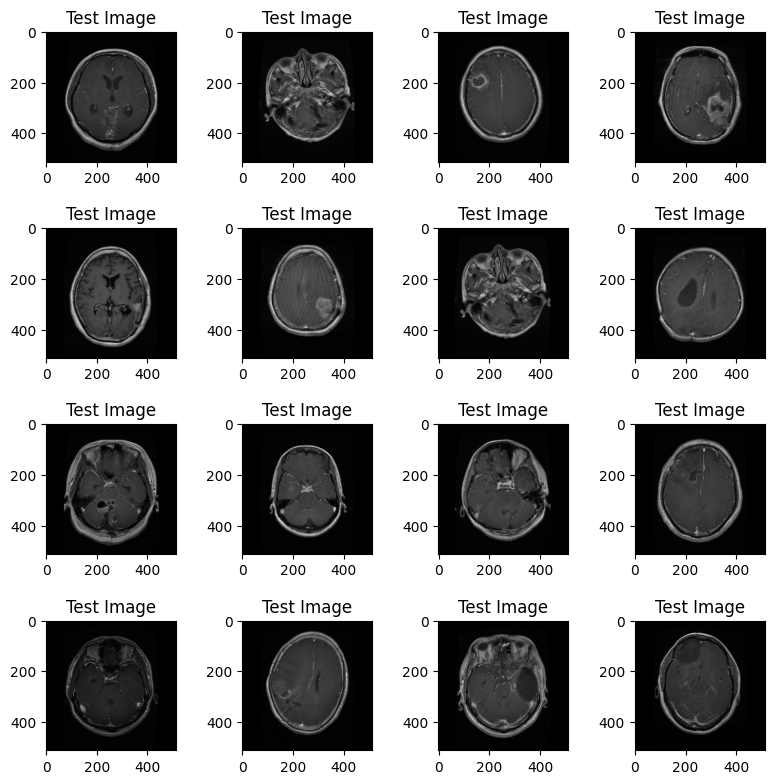

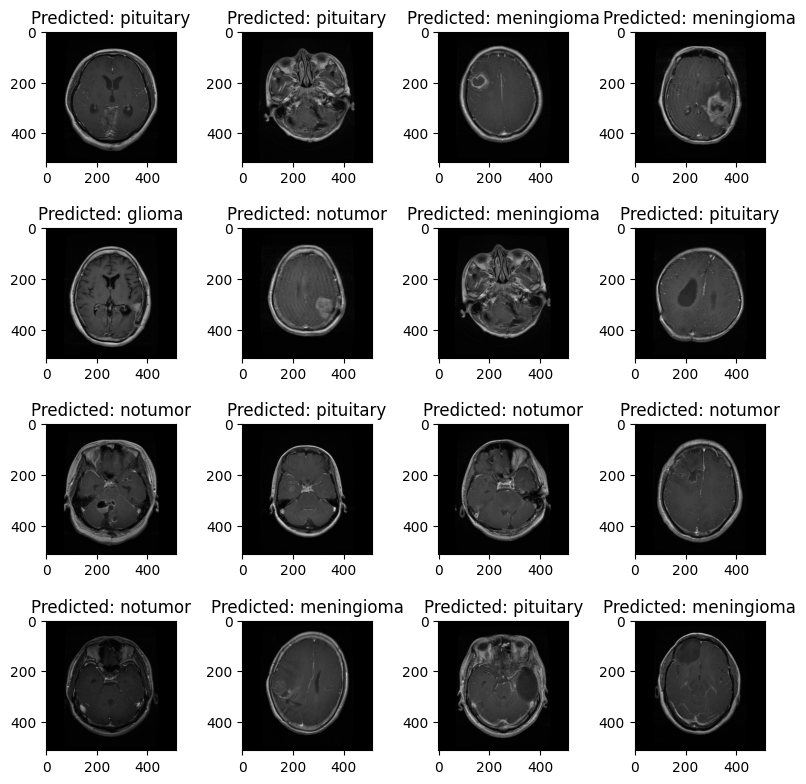

In [26]:
# Path ke folder testing di Drive Anda
test_path = Path("/content/drive/MyDrive/Kalbe/HW 2/Brain/Testing")

# Mengambil semua file gambar di folder testing
img_as_jpg_test = list(test_path.glob(r"*/*.jpg"))

# Membuat DataFrame untuk data testing
test = pd.concat([pd.Series(img_as_jpg_test, name="image").apply(str)], axis=1)

# Mengambil ukuran dataset testing
print("Shape of test dataset:", np.shape(test))

# Memuat model yang telah dilatih sebelumnya
model = ViTClassfier(hparams.image_size, hparams.n_classes)

# Memuat bobot model terlatih
model.load_weights('models/ViT_on_20_epochs.model')

# Menampilkan beberapa contoh gambar dari dataset testing
fig, axes = plt.subplots(4, 4, figsize=(8, 8))
fig.tight_layout()
counter = 0
for ax in axes.reshape(-1):
    ax.imshow(plt.imread(test["image"][counter]))
    ax.set_title("Test Image")
    plt.rcParams["axes.grid"] = False
    counter = counter + 1

# Menggunakan model untuk melakukan prediksi pada dataset testing
test_ds = tf.keras.preprocessing.image_dataset_from_directory(test_path, image_size=hparams.image_size[:-1], batch_size=hparams.batch_size)
test_ds.class_names = ds.class_names

predictions = model.predict(test_ds)

# Mengonversi prediksi menjadi kelas yang diharapkan
predicted_classes = np.argmax(predictions, axis=1)

# Menampilkan beberapa contoh hasil prediksi pada dataset testing
fig, axes = plt.subplots(4, 4, figsize=(8, 8))
fig.tight_layout()
counter = 0
for ax in axes.reshape(-1):
    ax.imshow(plt.imread(test["image"][counter]))
    ax.set_title(f"Predicted: {ds.class_names[predicted_classes[counter]]}")
    plt.rcParams["axes.grid"] = False
    counter = counter + 1

# Jika Anda memiliki label sebenarnya untuk dataset testing, Anda dapat menghitung akurasi
# dengan menggunakan metrik seperti balanced_accuracy_score dari scikit-learn.
# Pastikan bahwa urutan kelas pada dataset testing cocok dengan model.
# true_labels = ...
# acc_test = balanced_accuracy_score(true_labels, predicted_classes)
# print(f"Final accuracy on test set : {acc_test:.3f}")
